In [22]:
import matplotlib.pyplot as plt
import numpy as np

import gpflow
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
from xgboost import XGBRegressor

In [2]:
model_data = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/region_3_test_model_data_conif_vegc.csv')
# unique_bins = sorted(model_data.stand_age_interval_min.unique())
# bin_to_ordinal = {bin_val: idx for idx, bin_val in (enumerate(unique_bins))}
# print(bin_to_ordinal)
# model_data['ordinal_stand_age'] = model_data['stand_age_interval_min'].map(bin_to_ordinal)
# model_data['ordinal_stand_age'].describe()


{0: 0, 5: 1, 10: 2, 15: 3, 20: 4, 25: 5, 30: 6, 35: 7, 40: 8, 45: 9, 50: 10, 55: 11, 60: 12, 65: 13, 70: 14, 75: 15, 80: 16, 85: 17, 90: 18, 95: 19, 100: 20, 125: 21, 150: 22}


count    287630.000000
mean          9.834551
std           7.873397
min           0.000000
25%           3.000000
50%           8.000000
75%          17.000000
max          22.000000
Name: ordinal_stand_age, dtype: float64

In [7]:
variables_to_compare = ['monthly_mean', 'tswrf_v11', 'tmp', 'precip', 'dtr', 'vpr', 'wind','co2','Ndep_Trendy']

base_comparison = model_data.loc[model_data['year'].between(1900,1950)].groupby(
    ['lon','lat','ordinal_stand_age'])[variables_to_compare].mean().reset_index()


model_data=model_data.merge(base_comparison, on = ['lon','lat','ordinal_stand_age'], suffixes = ('_ts', '_base'))
model_data=model_data.loc[model_data['monthly_mean_base']!=0]
# Iterate over the list of variables and create new columns in model_data for their ratios
for var in variables_to_compare:
    ts_column = f"{var}_ts"     # Time series data column name
    base_column = f"{var}_base" # Baseline data column name
    ratio_column = f"{var}_ratio" # Name for the new ratio column

    # Compute the ratio and create a new column in model_data
    if (var =='precip') :
        model_data[ratio_column] = model_data[ts_column] / model_data[base_column]
    else:
        model_data[ratio_column] = model_data[ts_column] - model_data[base_column]


In [6]:
# running /five year temperature
# model_data.to_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/region_3_test_model_data_conif_vegc.csv', index=False)

In [19]:
model_data.monthly_mean_ratio.describe()
model_data[model_data.columns[model_data.columns.str.contains("ratio")]].describe()

,monthly_mean_ratio,tswrf_v11_ratio,tmp_ratio,precip_ratio,dtr_ratio,vpr_ratio,wind_ratio,co2_ratio,Ndep_Trendy_ratio
count,239450.000000,239450.000000,239450.000000,239450.000000,239450.000000,239450.000000,239450.000000,239450.000000,239450.000000
mean,215.144957,-0.216046,0.007487,1.010616,-0.166201,0.029323,-0.155192,16.312569,129.533789
std,1756.583901,5.045628,0.604008,0.179026,0.637799,0.487499,0.285388,35.532720,200.015019
min,-12849.330000,-26.400000,-1.870000,0.317427,-4.620000,-1.859412,-1.892564,-33.791765,-209.679661
25%,-416.555490,-3.115882,-0.384382,0.885728,-0.564314,-0.242941,-0.293069,-8.215294,-19.265504
50%,28.981863,-0.405800,-0.035882,1.002098,-0.169298,-0.012549,-0.069216,4.874348,22.788176
75%,764.485294,2.593529,0.359216,1.122296,0.213922,0.260784,0.030784,37.324706,287.053838
max,15451.202143,24.762941,3.268000,3.241784,2.558000,2.405000,0.900000,117.585000,747.300989


In [5]:
# len(model_data.loc[model_data['monthly_mean_ratio']>2 ])/len(model_data)

0.04390060555439549

In [9]:
model_data = model_data.loc[(model_data['year']>1950)]

(array([1.0000e+00, 0.0000e+00, 3.0000e+00, 1.1000e+01, 1.9000e+01,
        3.1000e+01, 1.0500e+02, 1.2800e+02, 1.3000e+02, 2.1900e+02,
        3.9200e+02, 6.5100e+02, 1.0610e+03, 1.7580e+03, 3.6760e+03,
        9.5730e+03, 2.9673e+04, 1.9824e+04, 1.4943e+04, 9.9940e+03,
        6.3760e+03, 4.1620e+03, 2.6290e+03, 1.4650e+03, 9.5400e+02,
        5.4800e+02, 3.2200e+02, 2.6700e+02, 2.3200e+02, 1.7300e+02,
        1.0600e+02, 1.1300e+02, 1.6800e+02, 1.1300e+02, 8.5000e+01,
        3.4000e+01, 2.8000e+01, 1.6000e+01, 1.3000e+01, 6.0000e+00]),
 array([-10868.54      , -10210.54644643,  -9552.55289286,  -8894.55933929,
         -8236.56578571,  -7578.57223214,  -6920.57867857,  -6262.585125  ,
         -5604.59157143,  -4946.59801786,  -4288.60446429,  -3630.61091071,
         -2972.61735714,  -2314.62380357,  -1656.63025   ,   -998.63669643,
          -340.64314286,    317.35041071,    975.34396429,   1633.33751786,
          2291.33107143,   2949.324625  ,   3607.31817857,   4265.31173214

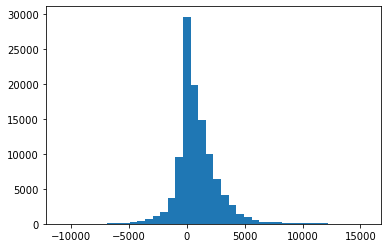

In [10]:
# model_data = model_data.loc[model_data['monthly_mean_ratio']<10]

plt.hist(model_data.monthly_mean_ratio, bins=40)

In [22]:
corr = model_data[model_data.columns[model_data.columns.str.contains('ratio')==True]].corr()


<Axes: >

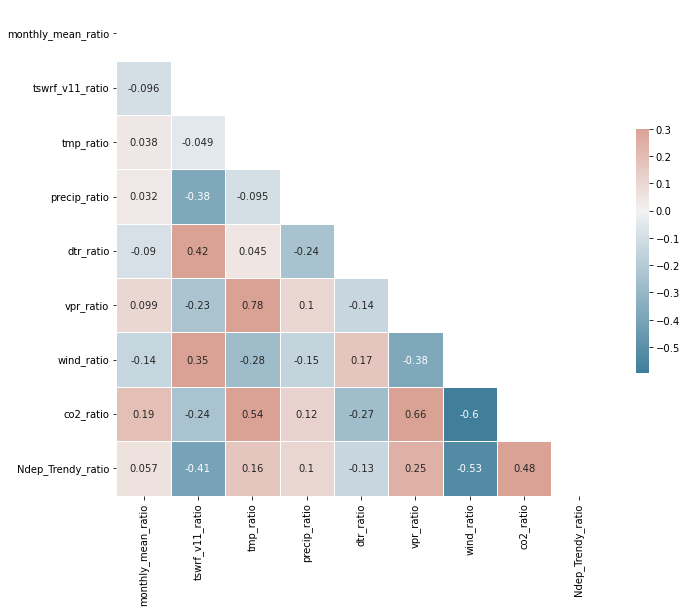

In [23]:
# Generate a large random dataset
# Compute the correlation matrix
corr = model_data[model_data.columns[model_data.columns.str.contains('ratio')==True]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [49]:
model_data.columns[model_data.columns.str.contains('ratio')==True]

Index(['monthly_mean_ratio', 'tswrf_v11_ratio', 'tmp_ratio', 'precip_ratio',
       'dtr_ratio', 'vpr_ratio', 'wind_ratio', 'co2_ratio',
       'Ndep_Trendy_ratio'],
      dtype='object')

In [50]:
len(model_data)

101600

In [17]:
####define training and testing set
# Define the features and target variable


X = model_data[['tswrf_v11_ratio', 'tmp_ratio', 'precip_ratio',
       'dtr_ratio', 'vpr_ratio', 'wind_ratio', 'co2_ratio', 'ordinal_stand_age']]
Y = np.array((model_data['monthly_mean_ratio']))

# scaler = preprocessing.StandardScaler().fit(X)
# X = scaler.transform(X)

# scaler = preprocessing.StandardScaler().fit(Y)
# Y = scaler.transform(Y)

# Y = np.sqrt(model_data['monthly_mean_ratio'])


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)



In [40]:
# Initialize XGBRegressor (you can specify hyperparameters as needed)
for depth in range(12, 20):
    for lr in [.1,.3]:

        xgb_model = XGBRegressor(max_depth=depth,learning_rate=lr)

        # Fit the model on the scaled data
        xgb_model.fit(X_train, y_train)

        # Make predictions (as an example, here we predict on the training data itself)
        # predictions = xgb_model.predict(X_scaled)
        print(f"training {depth} {lr}: ",xgb_model.score(X_train, y_train) )
        print(f"testing {depth} {lr}: ",xgb_model.score(X_test, y_test) )

training 12 0.1:  0.8981571433384448
testing 12 0.1:  0.6067633209847474
training 12 0.3:  0.9762389105853381
testing 12 0.3:  0.5897026961830341
training 13 0.1:  0.9300374525512618
testing 13 0.1:  0.6090566437917997
training 13 0.3:  0.9883292181246554
testing 13 0.3:  0.5916968194273049
training 14 0.1:  0.956857600342486
testing 14 0.1:  0.6125626802801011
training 14 0.3:  0.9957237130606332
testing 14 0.3:  0.5953020102885718
training 15 0.1:  0.9754792930832502
testing 15 0.1:  0.607858805893353
training 15 0.3:  0.9987715050257961
testing 15 0.3:  0.5900265685314416
training 16 0.1:  0.985389601944615
testing 16 0.1:  0.6063249736989706
training 16 0.3:  0.999575322195478
testing 16 0.3:  0.5851673227096378
training 17 0.1:  0.9923106699753822
testing 17 0.1:  0.6011794192884634
training 17 0.3:  0.9998766409937551
testing 17 0.3:  0.5812781861364021
training 18 0.1:  0.9958653822309452
testing 18 0.1:  0.5998893689633626
training 18 0.3:  0.9999801648421158
testing 18 0.3:  0

In [32]:
print("training: ",xgb_model.score(X_train, y_train) )


training:  0.9999970041545916


In [36]:

for i in range(5, 20):
    regr = RandomForestRegressor(max_depth=i, random_state=0)
    regr.fit(X_train, y_train)
    print(f"training {i}: ",regr.score(X_train, y_train) )
    print(f"testing {i}: ",regr.score(X_test, y_test) )

training 5:  0.3671468376633412
testing 5:  0.35424060171730865
training 6:  0.4088871943387751
testing 6:  0.39376302962866216
training 7:  0.44816152455475844
testing 7:  0.4284032905455669
training 8:  0.4892567462801155
testing 8:  0.4585958167332639
training 9:  0.5323566415659362
testing 9:  0.4861607933933112
training 10:  0.5761698065440315
testing 10:  0.5089846663923562
training 11:  0.6196809515632076
testing 11:  0.5281632588502727
training 12:  0.662592952735497
testing 12:  0.5437448902517603
training 13:  0.7042653017448455
testing 13:  0.5583077970255548
training 14:  0.7436890644557368
testing 14:  0.5708865642906212
training 15:  0.7793204776482552
testing 15:  0.5809672647346762
training 16:  0.8107676027400393
testing 16:  0.5890285058257179
training 17:  0.837967411305709
testing 17:  0.5955876890920578
training 18:  0.8607060803118912
testing 18:  0.6005037613238686
training 19:  0.8793377365921528
testing 19:  0.6042881464321135


In [26]:
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)



In [27]:
svr_rbf.fit(X_train, y_train)
svr_rbf.score(X_test, y_test)

0.3634187214250043

In [ ]:
svr_lin.fit(X_train, y_train)
svr_lin.score(X_test, y_test)

In [ ]:
svr_poly.fit(X_train, y_train)
svr_poly.score(X_test, y_test)